# F1-Circuit Recognition

Using the [F1 Circuit dataset](https://github.com/bacinger/f1-circuits) we will train a model to recognize the circuit from an image.

In [1]:
# import dependencies

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random

## Data Preparation, pre-processing, and augmentation

In [6]:
import os
import cv2

# Function to resize an image to a fixed shape
def resize_image(image, target_shape):
    return cv2.resize(image, target_shape, interpolation=cv2.INTER_AREA)

# Path to the folder containing the images
folder_path = "output_images"

# Get a list of all subfolders (classes)
classes = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
num_classes = len(classes)

# Initialize variables to store the dimensions of the first image
first_image_path = os.path.join(folder_path, classes[0], os.listdir(os.path.join(folder_path, classes[0]))[0])
first_image = cv2.imread(first_image_path)
image_shape = first_image.shape

# Fixed shape to resize the images
target_shape = (100, 100)  # Change this to your desired shape

# Resize all images to the fixed shape
for class_name in classes:
    class_folder_path = os.path.join(folder_path, class_name)
    for image_file in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_file)
        image = cv2.imread(image_path)
        resized_image = resize_image(image, target_shape)
        cv2.imwrite(image_path, resized_image)

print("Images resized to shape:", target_shape)

Images resized to shape: (100, 100)


In [7]:
import os
import random
from sklearn.model_selection import train_test_split
from shutil import copyfile

# Path to the folder containing the images
folder_path = "output_images"

# Get a list of all subfolders (classes)
classes = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

# Create directories for train and test data
train_path = "data/train_data"
test_path = "data/test_data"
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate over each class
for class_name in classes:
    class_folder_path = os.path.join(folder_path, class_name)
    # Get list of image files in the class folder
    image_files = [os.path.join(class_folder_path, file) for file in os.listdir(class_folder_path) if file.endswith(".png")]
    # Split the images into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=0.1, random_state=42)
    
    # Copy images to train folder
    for train_file in train_files:
        dest_folder = os.path.join(train_path, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(train_file, os.path.join(dest_folder, os.path.basename(train_file)))
    
    # Copy images to test folder
    for test_file in test_files:
        dest_folder = os.path.join(test_path, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(test_file, os.path.join(dest_folder, os.path.basename(test_file)))


In [12]:
import os
import cv2
import numpy as np

# Function to load images and their corresponding labels
def load_data(folder_path):
    images = []
    labels = []
    classes = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    for class_idx, class_name in enumerate(classes):
        class_folder_path = os.path.join(folder_path, class_name)
        for image_file in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_file)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(class_idx)
    return np.array(images), np.array(labels)

# Path to the folder containing the images
folder_path = "data"  # Change this to your folder containing train_data and test_data folders

# Load train and test data
X_train, y_train = load_data(os.path.join(folder_path, "train_data"))
X_test, y_test = load_data(os.path.join(folder_path, "test_data"))

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

Looking at this data we can see that there is a bit of a class imbalance.We will need to do some data augmentation to help with the class imbalance.

In [13]:
# create an ImageDataGenerator for data augmentation

datagen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

## Model Creation

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

images_classes = len(np.unique(y_train))

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(images_classes, activation='softmax'))

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model with data augmentation
fitted_model = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=200,
    callbacks=[early_stopping]
)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.0449 - loss: 3.5393 - val_accuracy: 0.2714 - val_loss: 3.3609
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.1081 - loss: 3.3950 - val_accuracy: 0.5524 - val_loss: 2.5230
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.1958 - loss: 2.9358 - val_accuracy: 0.9429 - val_loss: 1.2109
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.3238 - loss: 2.3604 - val_accuracy: 0.9810 - val_loss: 0.3530
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.4746 - loss: 1.8172 - val_accuracy: 1.0000 - val_loss: 0.1016
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.5493 - loss: 1.4619 - val_accuracy: 1.0000 - val_loss: 0.0358
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.6454 - loss: 1.2261 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.6783 - loss: 1.0336 - val_

In [20]:
# save model

model.save("models/f1-model.h5")

## Evaluation

In [21]:
# load model and show summary

loaded_model = load_model('models/f1-model.h5')
loaded_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,787,685 (25.89 MB)

 Trainable params: 6,787,683 (25.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

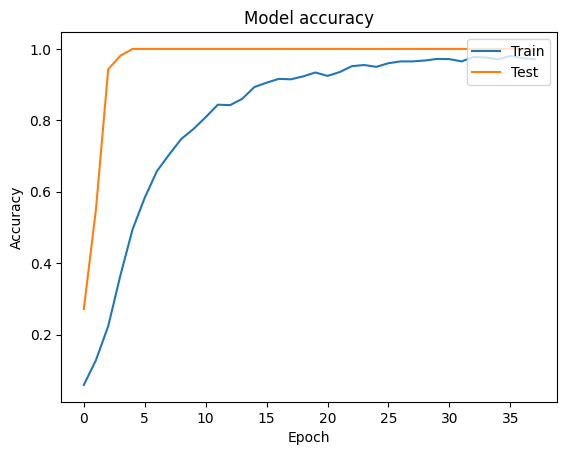

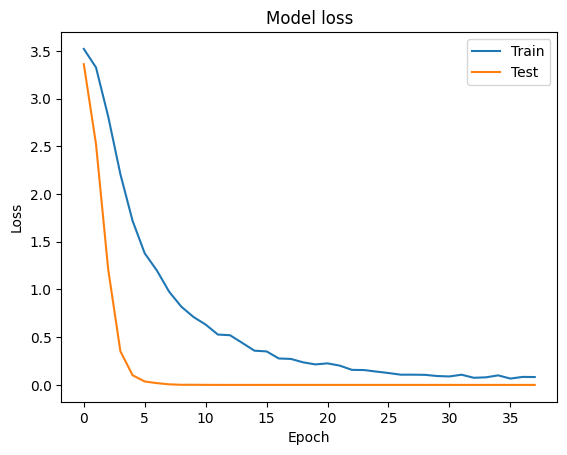

In [22]:
# Plot training & validation accuracy values

plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation loss values

plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [23]:
# evaluating the model

loss, accuracy = model.evaluate(X_test, y_test)
print(f"loss: {str(loss)}\n accuracy: {str(accuracy)}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 1.1004e-07
loss: 1.8903169518580398e-07
 accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


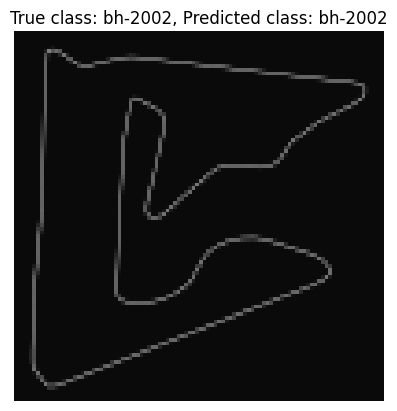

In [24]:
# take a random image from the test data and predict the class
# also show the image and the true class

random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
random_label = y_test[random_index]

# Reshape the image to the shape the model expects
random_image = random_image.reshape(1, 100, 100, 3)

# Predict the class of the image
prediction = model.predict(random_image)
predicted_class = np.argmax(prediction)

# Load the class names
class_names = [folder for folder in os.listdir(os.path.join(folder_path, "train_data")) if os.path.isdir(os.path.join(folder_path, "train_data", folder))]
true_class = class_names[random_label]
predicted_class_name = class_names[predicted_class]

# Display the image
plt.imshow(random_image.reshape(100, 100, 3))
plt.axis('off')
plt.title(f"True class: {true_class}, Predicted class: {predicted_class_name}")
plt.show()